In [225]:
import torch
import torchvision
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [226]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

gc.collect()

108669

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [274]:
# train transforms aplying random changes in train images to make training more robust
train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(500, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# val transforms to make sure validation set is setup correctly
val_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Base dataset with NO transform
base_dataset = datasets.ImageFolder(root=data_dir)
targets = np.array(base_dataset.targets)   # labels

# setup k fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# setup different datasets for different batch sizes
train_loaders = []
val_loaders   = []

train_loaders2 = []
val_loaders2   = []

train_loaders3 = []
val_loaders3   = []

# main cv logic setup
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(base_dataset)), targets)):

    print(f"Preparing Stratified Fold {fold_idx+1}")

    # setup training data set based on the train_idx index specified from skf
    train_dataset = Subset(
        datasets.ImageFolder(root=data_dir, transform=train_transform),
        train_idx
    )

    # setup validation data set based on the val_idx index specified from skf
    val_dataset = Subset(
        datasets.ImageFolder(root=data_dir, transform=val_transform),
        val_idx
    )

    # load data into respective array. each array should have 5 obects in it for each 5 folds
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=5, shuffle=False)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)

    train_loaders2.append(train_loader)
    val_loaders2.append(val_loader)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False)

    train_loaders3.append(train_loader)
    val_loaders3.append(val_loader)

Preparing Stratified Fold 1
Preparing Stratified Fold 2
Preparing Stratified Fold 3
Preparing Stratified Fold 4
Preparing Stratified Fold 5


In [261]:
# final data set used for final training on best model with batch of 5
final_train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
final_train_loader = DataLoader(final_train_dataset, batch_size=5, shuffle=True)

In [229]:
# inital first model architecture
def create_model():
    out_channels = 16

    model = nn.Sequential(

        # Block 1
        nn.Conv2d(3, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 500 -> 250

        # Block 2
        nn.Conv2d(out_channels, out_channels*2, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 250 -> 125

        # Block 3
        nn.Conv2d(out_channels*2, out_channels*3, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 125 -> 62

        # Block 4
        nn.Conv2d(out_channels*3, out_channels*4, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 62 -> 31

        # Block 5
        nn.Conv2d(out_channels*4, out_channels*5, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 31 -> 15

        # Flatten for FC layer
        nn.Flatten(),

        # Fully connected classifier
        nn.Linear(out_channels*5 * 15 * 15, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 2)
    )

    return model.to(device)

In [230]:
# second model architecture after tuning from first model and slight architecture changes
def create_model2():
    out_channels = 16
    model = nn.Sequential(

        # Block 1
        nn.Conv2d(3, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 500 -> 250

        # Block 2
        nn.Conv2d(out_channels, out_channels*2, 3, padding=1),
        nn.BatchNorm2d(out_channels*2),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 250 -> 125

        # Block 3
        nn.Conv2d(out_channels*2, out_channels*4, 3, padding=1),
        nn.BatchNorm2d(out_channels*4),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 125 -> 62

        # Block 4
        nn.Conv2d(out_channels*4, out_channels*8, 3, padding=1),
        nn.BatchNorm2d(out_channels*8),
        nn.ReLU(),
        nn.MaxPool2d(2),     # 62 -> 31

        # Global Avg Pool to get down to 1x1 for fast training in fc
        nn.AdaptiveAvgPool2d((1, 1)),

        nn.Flatten(),

        nn.Linear(out_channels*8, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)
    )

    return model.to(device)


In [231]:
# train logic pulled from in class assigments
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
# set seed and num of epochs and model recording varibales
torch.manual_seed(1)
num_epochs = 40

hist = []
hist2 = []

trained_models = []
trained_models_2 = []

# start of model 2
print("MODEL 2 START")
for fold in range(5):
    print(f"\n===== Training Fold {fold+1} =====")

    model = create_model2()       # build a fresh model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_dl = train_loaders[fold]
    val_dl   = val_loaders[fold]

    hist2.append(train(model, num_epochs, train_dl, val_dl))

    trained_models_2.append(model)

In [233]:
# start of model 1
print("MODEL 1 START")
for fold in range(5):
    print(f"\n===== Training Fold {fold+1} =====")

    model = create_model()       # build a fresh model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_dl = train_loaders[fold]
    val_dl   = val_loaders[fold]

    hist.append(train(model, num_epochs, train_dl, val_dl))

    trained_models.append(model)

MODEL 1 START

===== Training Fold 1 =====
Epoch 1 accuracy: 0.5417 val_accuracy: 0.5833
Epoch 2 accuracy: 0.6458 val_accuracy: 0.5833
Epoch 3 accuracy: 0.5833 val_accuracy: 0.5833
Epoch 4 accuracy: 0.6458 val_accuracy: 0.8333
Epoch 5 accuracy: 0.7708 val_accuracy: 0.6667
Epoch 6 accuracy: 0.8333 val_accuracy: 0.7500
Epoch 7 accuracy: 0.8125 val_accuracy: 0.7500
Epoch 8 accuracy: 0.7500 val_accuracy: 0.5833
Epoch 9 accuracy: 0.6875 val_accuracy: 0.8333
Epoch 10 accuracy: 0.8125 val_accuracy: 0.6667
Epoch 11 accuracy: 0.8958 val_accuracy: 0.7500
Epoch 12 accuracy: 0.8333 val_accuracy: 0.7500
Epoch 13 accuracy: 0.8958 val_accuracy: 0.7500
Epoch 14 accuracy: 0.9375 val_accuracy: 0.7500
Epoch 15 accuracy: 0.8958 val_accuracy: 0.8333
Epoch 16 accuracy: 0.7917 val_accuracy: 0.8333
Epoch 17 accuracy: 0.8750 val_accuracy: 0.6667
Epoch 18 accuracy: 0.8750 val_accuracy: 0.7500
Epoch 19 accuracy: 0.9167 val_accuracy: 0.7500
Epoch 20 accuracy: 0.9583 val_accuracy: 0.7500
Epoch 21 accuracy: 0.9375 

In [239]:
# diagnosis of models
mean_final_acc = np.mean([hist[i][3][-1] for i in range(5)])
print("Model 1 Mean accuracy:", mean_final_acc)

mean_final_acc = np.mean([hist2[i][3][-1] for i in range(5)])
print("Model 2 Mean accuracy:", mean_final_acc)

Model 1 Mean accuracy: 0.7833333
Model 2 Mean accuracy: 0.8833333


In [253]:
# 3rd model setup
hist3 = []
trained_models_3 = []


print("MODEL 3 START")
for fold in range(5):
    print(f"\n===== Training Fold {fold+1} =====")

    model = create_model2()       # build a fresh model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_dl = train_loaders2[fold]
    val_dl   = val_loaders2[fold]

    hist3.append(train(model, num_epochs, train_dl, val_dl))

    trained_models_3.append(model)

MODEL 3 START

===== Training Fold 1 =====
Epoch 1 accuracy: 0.6250 val_accuracy: 0.6667
Epoch 2 accuracy: 0.8125 val_accuracy: 0.5833
Epoch 3 accuracy: 0.8750 val_accuracy: 0.8333
Epoch 4 accuracy: 0.7083 val_accuracy: 0.8333
Epoch 5 accuracy: 0.8333 val_accuracy: 0.9167
Epoch 6 accuracy: 0.8750 val_accuracy: 0.9167
Epoch 7 accuracy: 0.8750 val_accuracy: 0.8333
Epoch 8 accuracy: 0.8542 val_accuracy: 0.8333
Epoch 9 accuracy: 0.7917 val_accuracy: 0.7500
Epoch 10 accuracy: 0.8333 val_accuracy: 0.9167
Epoch 11 accuracy: 0.8750 val_accuracy: 0.9167
Epoch 12 accuracy: 0.9583 val_accuracy: 0.9167
Epoch 13 accuracy: 0.9167 val_accuracy: 0.9167
Epoch 14 accuracy: 0.8750 val_accuracy: 0.9167
Epoch 15 accuracy: 0.8333 val_accuracy: 0.9167
Epoch 16 accuracy: 0.8542 val_accuracy: 0.9167
Epoch 17 accuracy: 0.9375 val_accuracy: 0.9167
Epoch 18 accuracy: 1.0000 val_accuracy: 0.9167
Epoch 19 accuracy: 0.8125 val_accuracy: 0.9167
Epoch 20 accuracy: 0.9167 val_accuracy: 0.9167
Epoch 21 accuracy: 0.8958 

In [254]:
mean_final_acc = np.mean([hist3[i][3][-1] for i in range(5)])
print("Model 3 Mean accuracy:", mean_final_acc)

Model 3 Mean accuracy: 0.8166666


In [267]:
# 4th model setup
hist4 = []
trained_models_4 = []

print("MODEL 4 START")
for fold in range(5):
    print(f"\n===== Training Fold {fold+1} =====")

    model = create_model2()       # build a fresh model

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_dl = train_loaders3[fold]
    val_dl   = val_loaders3[fold]

    hist4.append(train(model, num_epochs, train_dl, val_dl))

    trained_models_4.append(model)

MODEL 4 START

===== Training Fold 1 =====
Epoch 1 accuracy: 0.5625 val_accuracy: 0.5000
Epoch 2 accuracy: 0.6667 val_accuracy: 0.7500
Epoch 3 accuracy: 0.6042 val_accuracy: 0.7500
Epoch 4 accuracy: 0.7083 val_accuracy: 0.8333
Epoch 5 accuracy: 0.7708 val_accuracy: 0.8333
Epoch 6 accuracy: 0.7500 val_accuracy: 0.8333
Epoch 7 accuracy: 0.7708 val_accuracy: 0.8333
Epoch 8 accuracy: 0.7917 val_accuracy: 0.8333
Epoch 9 accuracy: 0.7083 val_accuracy: 0.9167
Epoch 10 accuracy: 0.7917 val_accuracy: 0.9167
Epoch 11 accuracy: 0.8125 val_accuracy: 0.9167
Epoch 12 accuracy: 0.6667 val_accuracy: 0.8333
Epoch 13 accuracy: 0.5833 val_accuracy: 0.8333
Epoch 14 accuracy: 0.6667 val_accuracy: 0.7500
Epoch 15 accuracy: 0.7083 val_accuracy: 0.8333
Epoch 16 accuracy: 0.7708 val_accuracy: 0.9167
Epoch 17 accuracy: 0.6458 val_accuracy: 0.8333
Epoch 18 accuracy: 0.7292 val_accuracy: 0.8333
Epoch 19 accuracy: 0.7708 val_accuracy: 0.9167
Epoch 20 accuracy: 0.8125 val_accuracy: 0.9167
Epoch 21 accuracy: 0.8125 

In [270]:
mean_final_acc = np.mean([hist4[i][3][-1] for i in range(5)])
print("Model 4 Mean accuracy:", mean_final_acc)

Model 4 Mean accuracy: 0.85


In [236]:
# logic to plot histories of accuracy and loss over each fold and epoch
def plot_histories(histories, model_name="Model"):
    num_folds = len(histories)

    fig, axes = plt.subplots(num_folds, 2, figsize=(12, 4 * num_folds))
    if num_folds == 1:
        axes = [axes]  # handle single-fold case

    for fold in range(num_folds):
        train_loss = histories[fold][0]
        val_loss = histories[fold][1]
        train_acc = histories[fold][2]
        val_acc = histories[fold][3]

        epochs = np.arange(1, len(train_loss) + 1)

        # --- LOSS PLOT ---
        ax_loss = axes[fold][0]
        ax_loss.plot(epochs, train_loss, label="Train Loss", marker="o")
        ax_loss.plot(epochs, val_loss, label="Val Loss", marker="x", linestyle="--")
        ax_loss.set_title(f"{model_name} Fold {fold+1} - Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()

        # --- ACCURACY PLOT ---
        ax_acc = axes[fold][1]
        ax_acc.plot(epochs, train_acc, label="Train Acc", marker="o")
        ax_acc.plot(epochs, val_acc, label="Val Acc", marker="x", linestyle="--")
        ax_acc.set_title(f"{model_name} Fold {fold+1} - Accuracy")
        ax_acc.set_xlabel("Epoch")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.set_ylim(0, 1.05)
        ax_acc.legend()

    plt.tight_layout()
    plt.show()


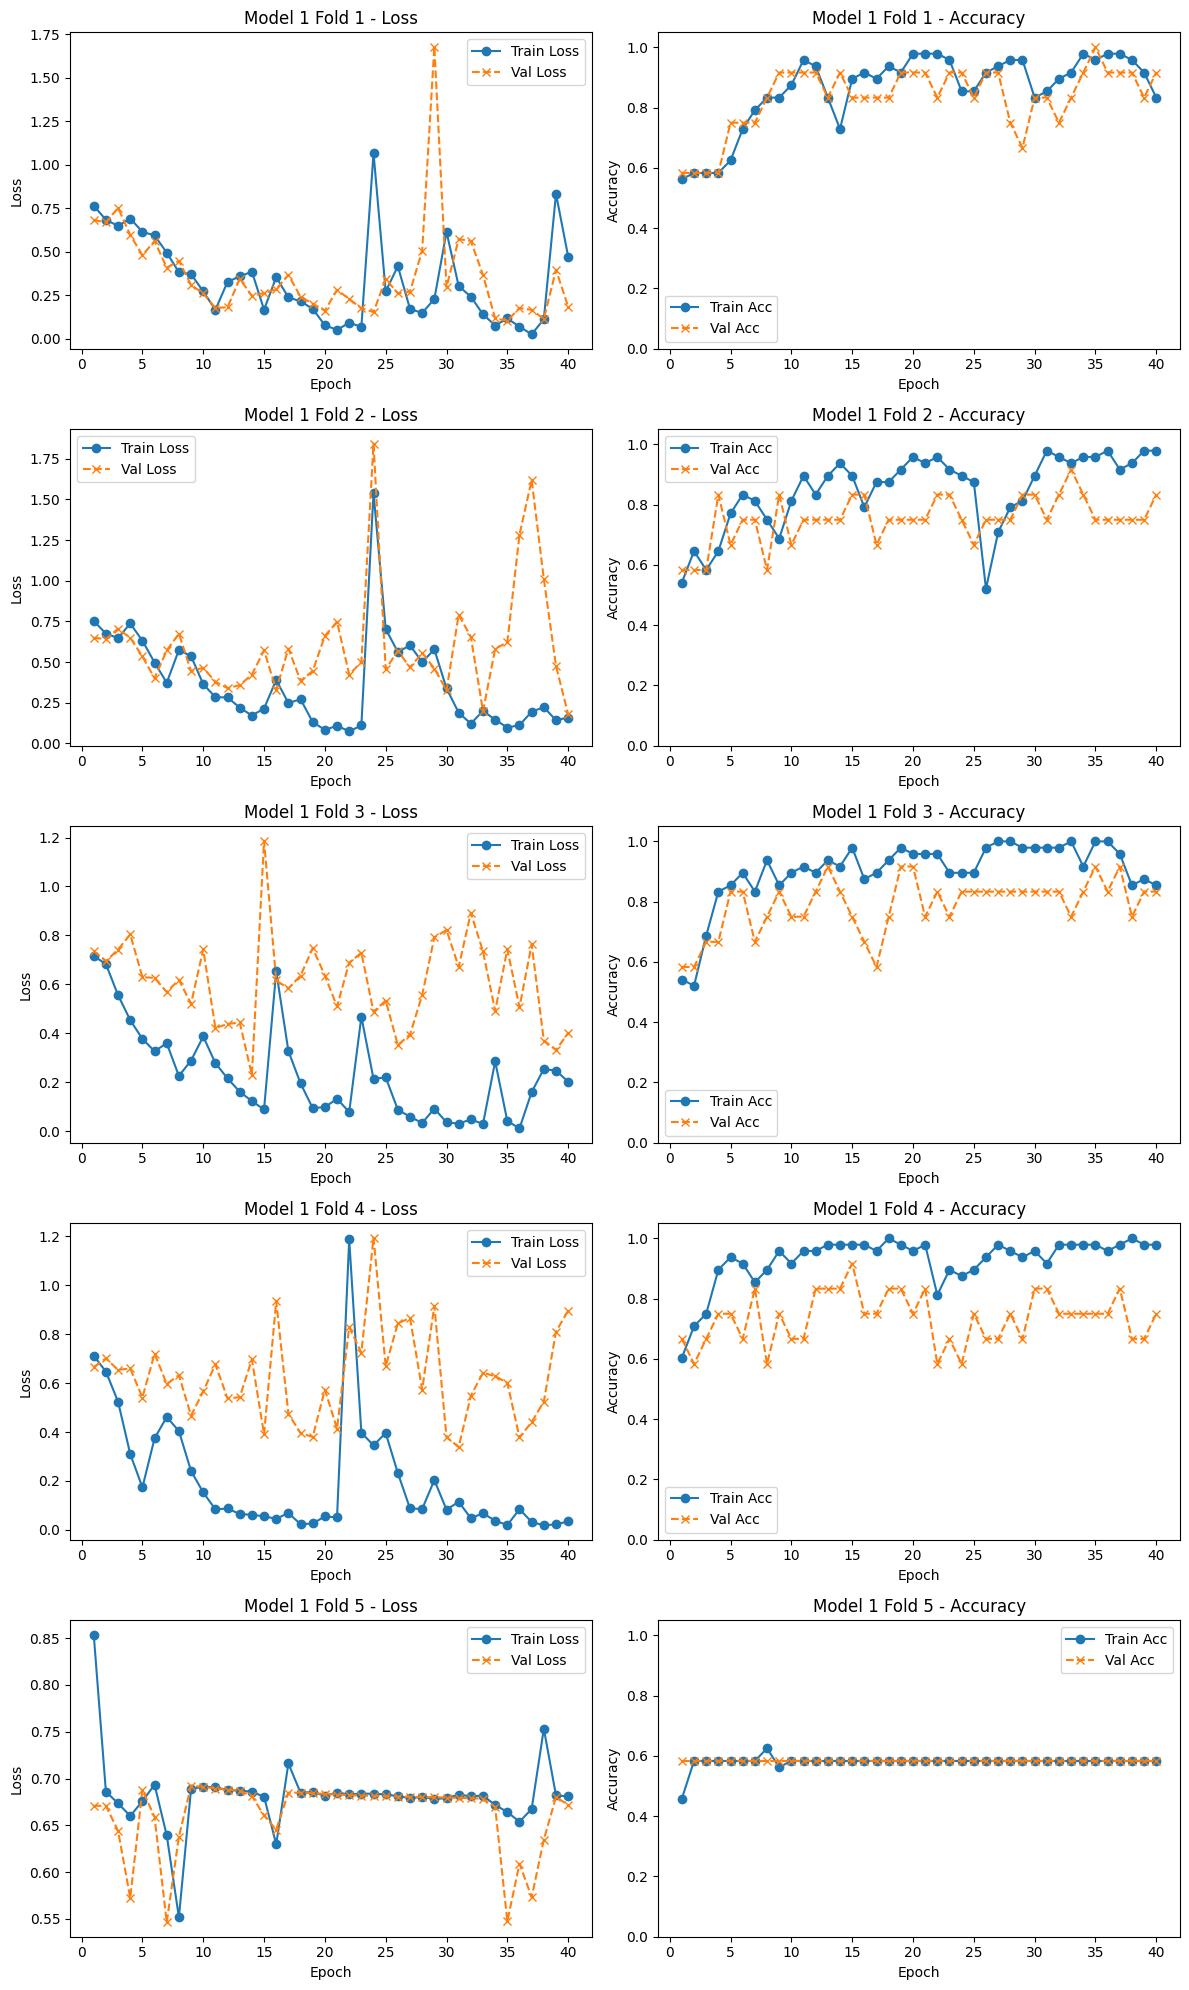

In [240]:
plot_histories(hist, model_name="Model 1")

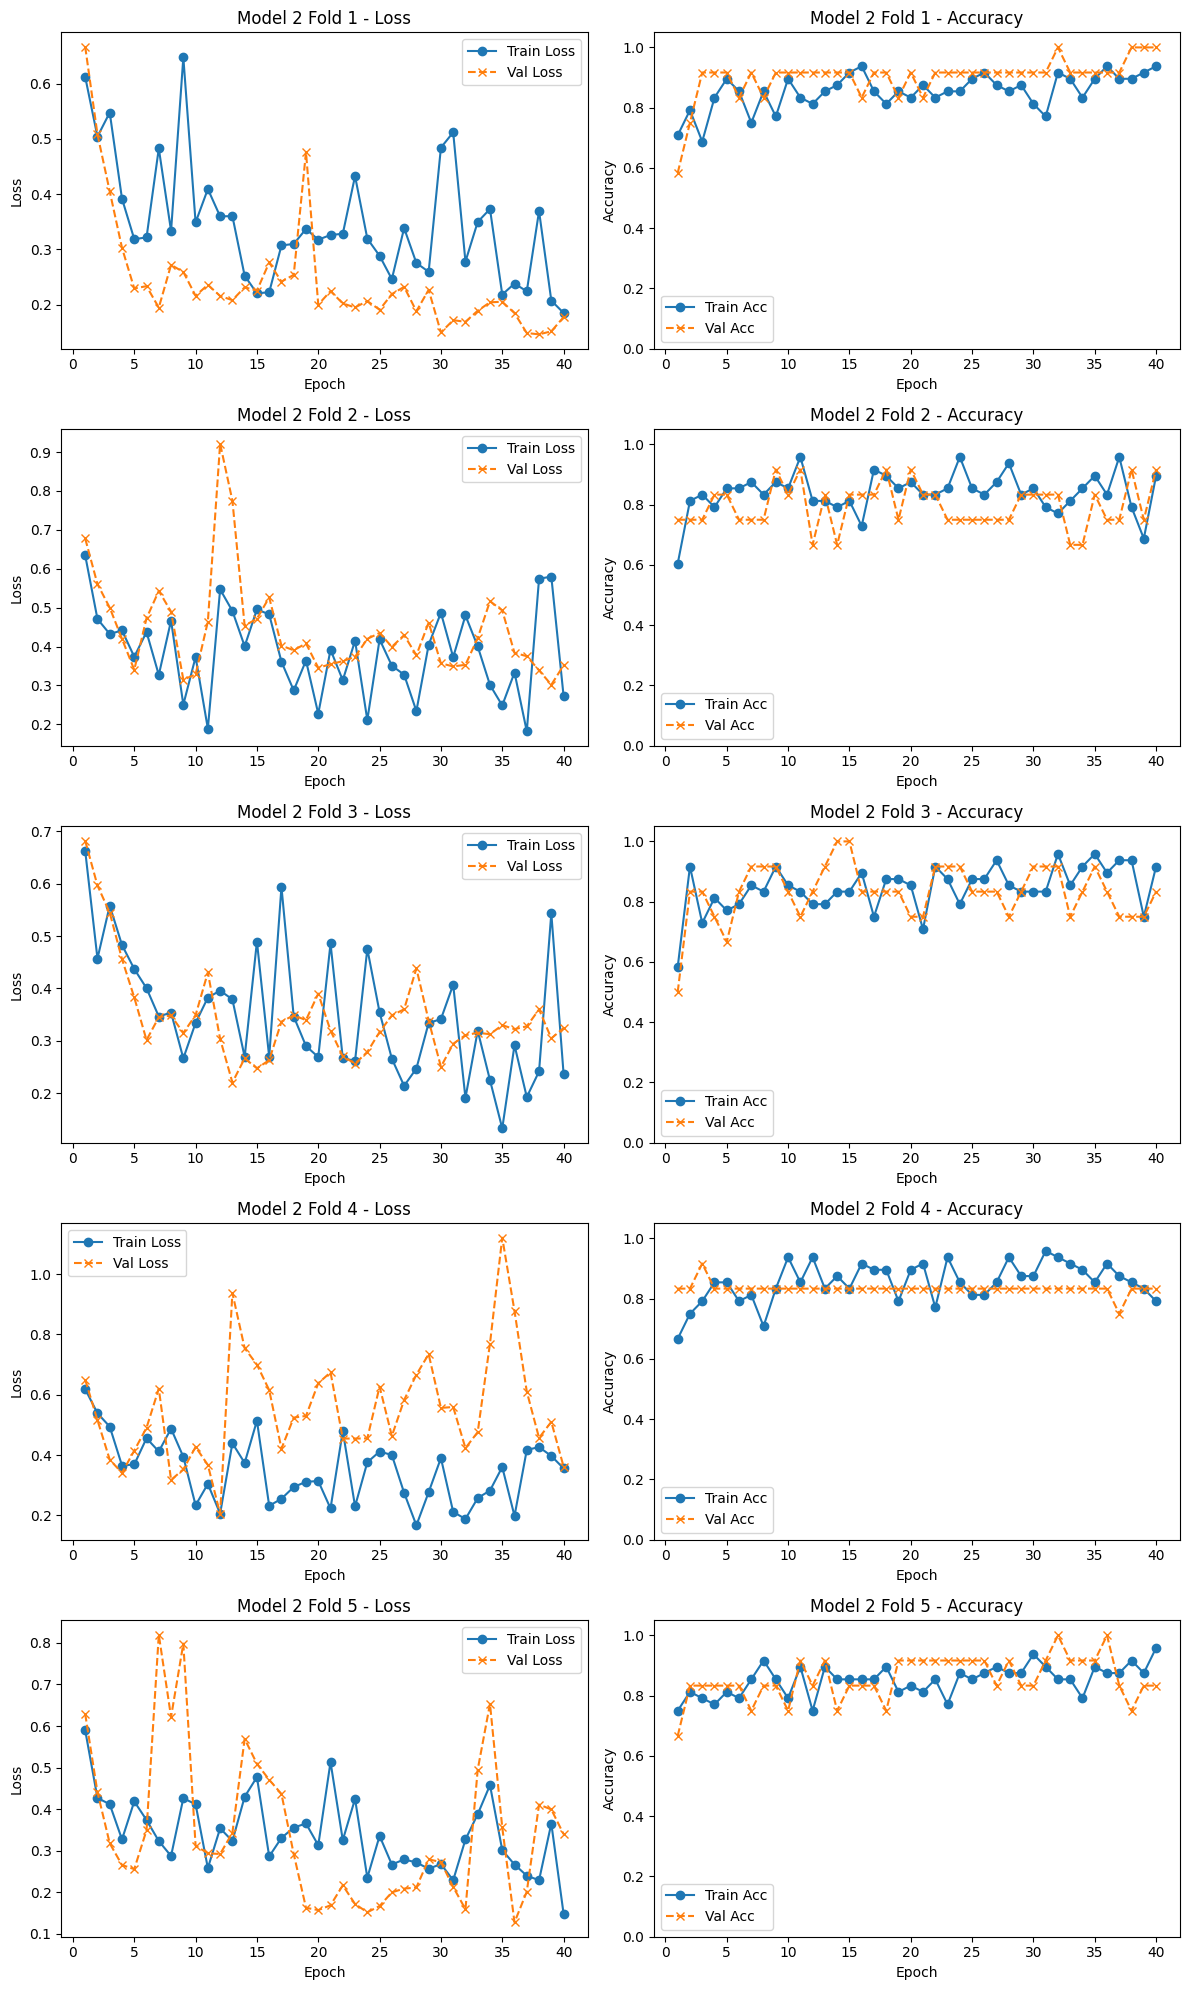

In [241]:
plot_histories(hist2, model_name="Model 2")

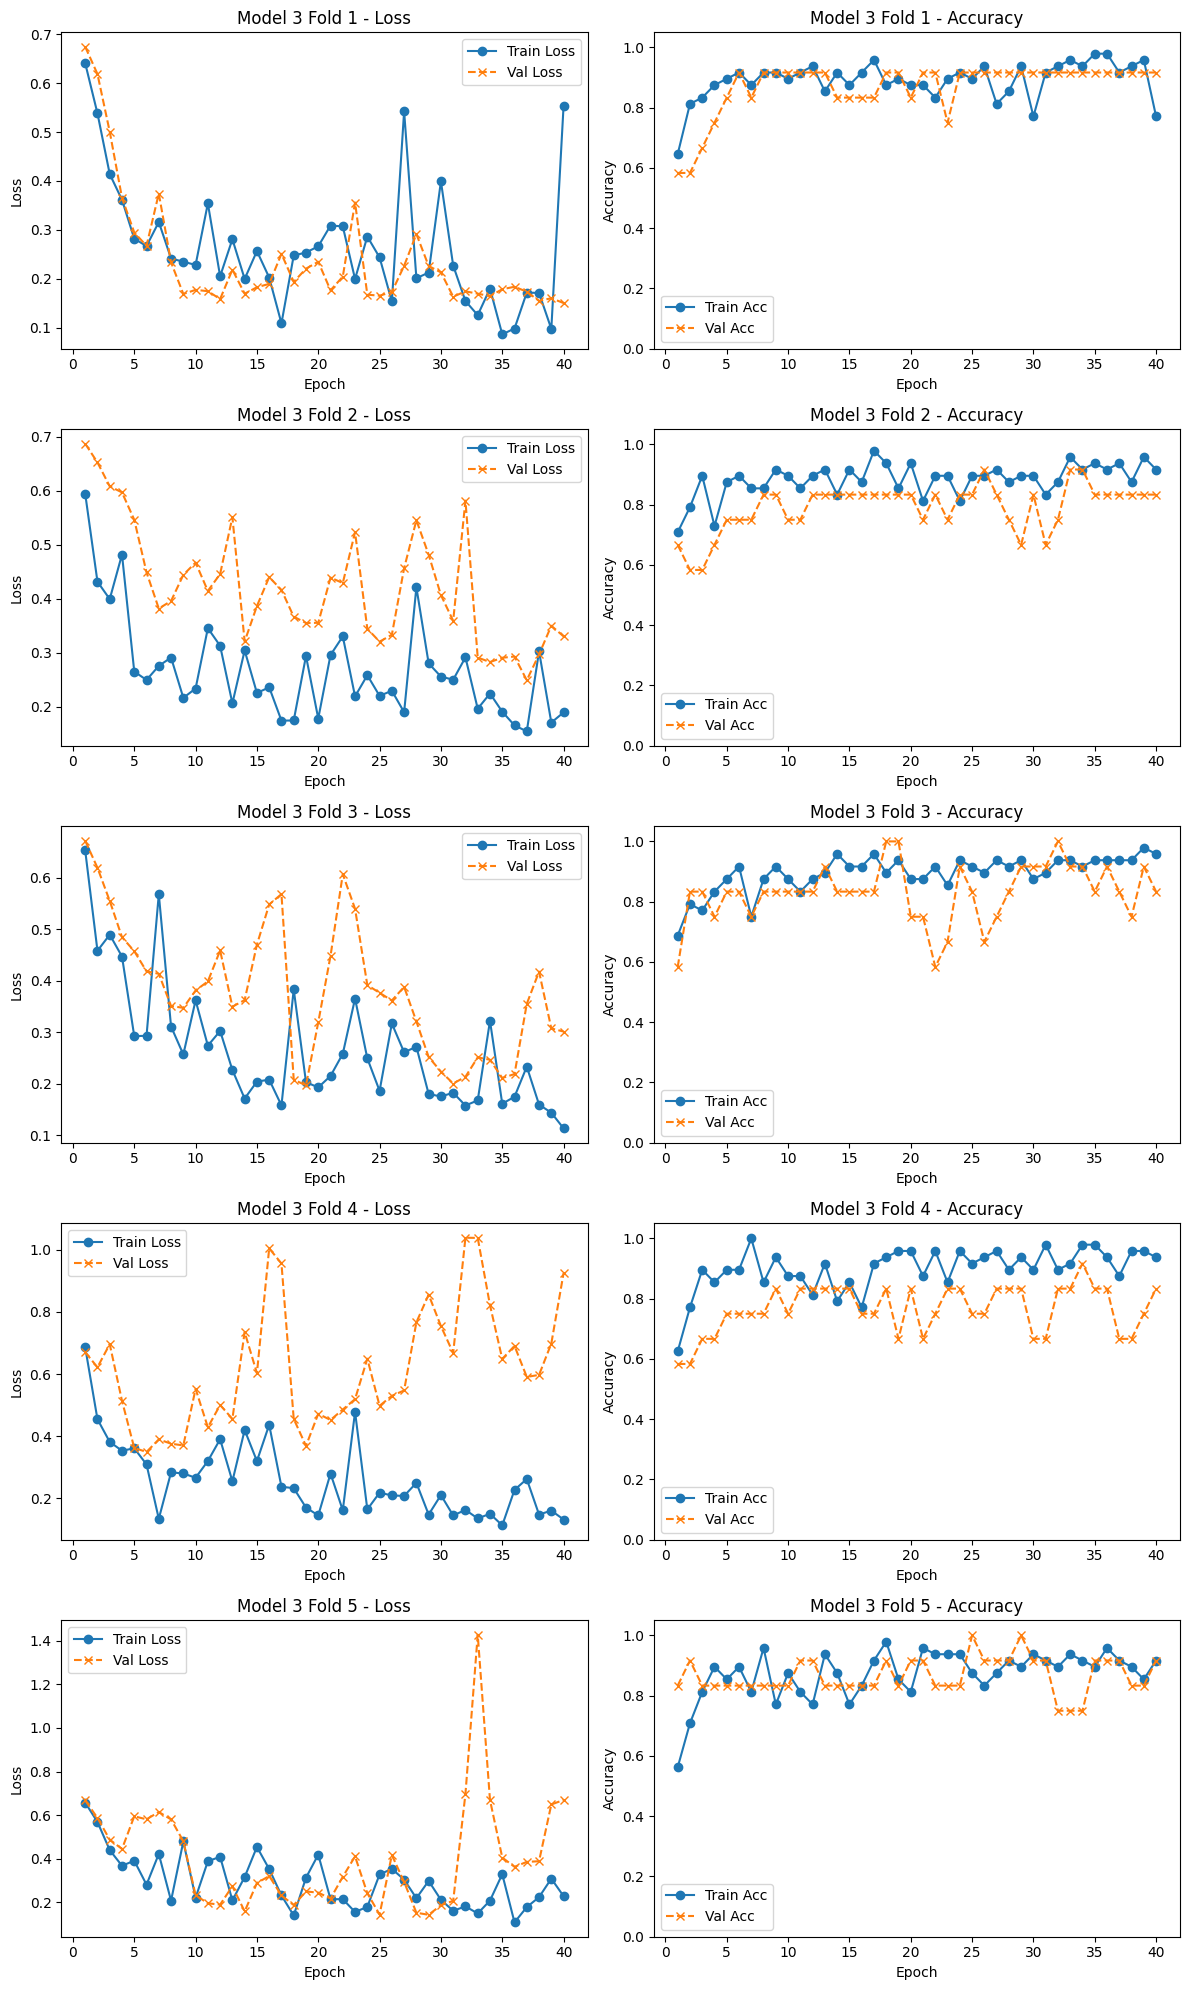

In [242]:
plot_histories(hist3, model_name="Model 3")

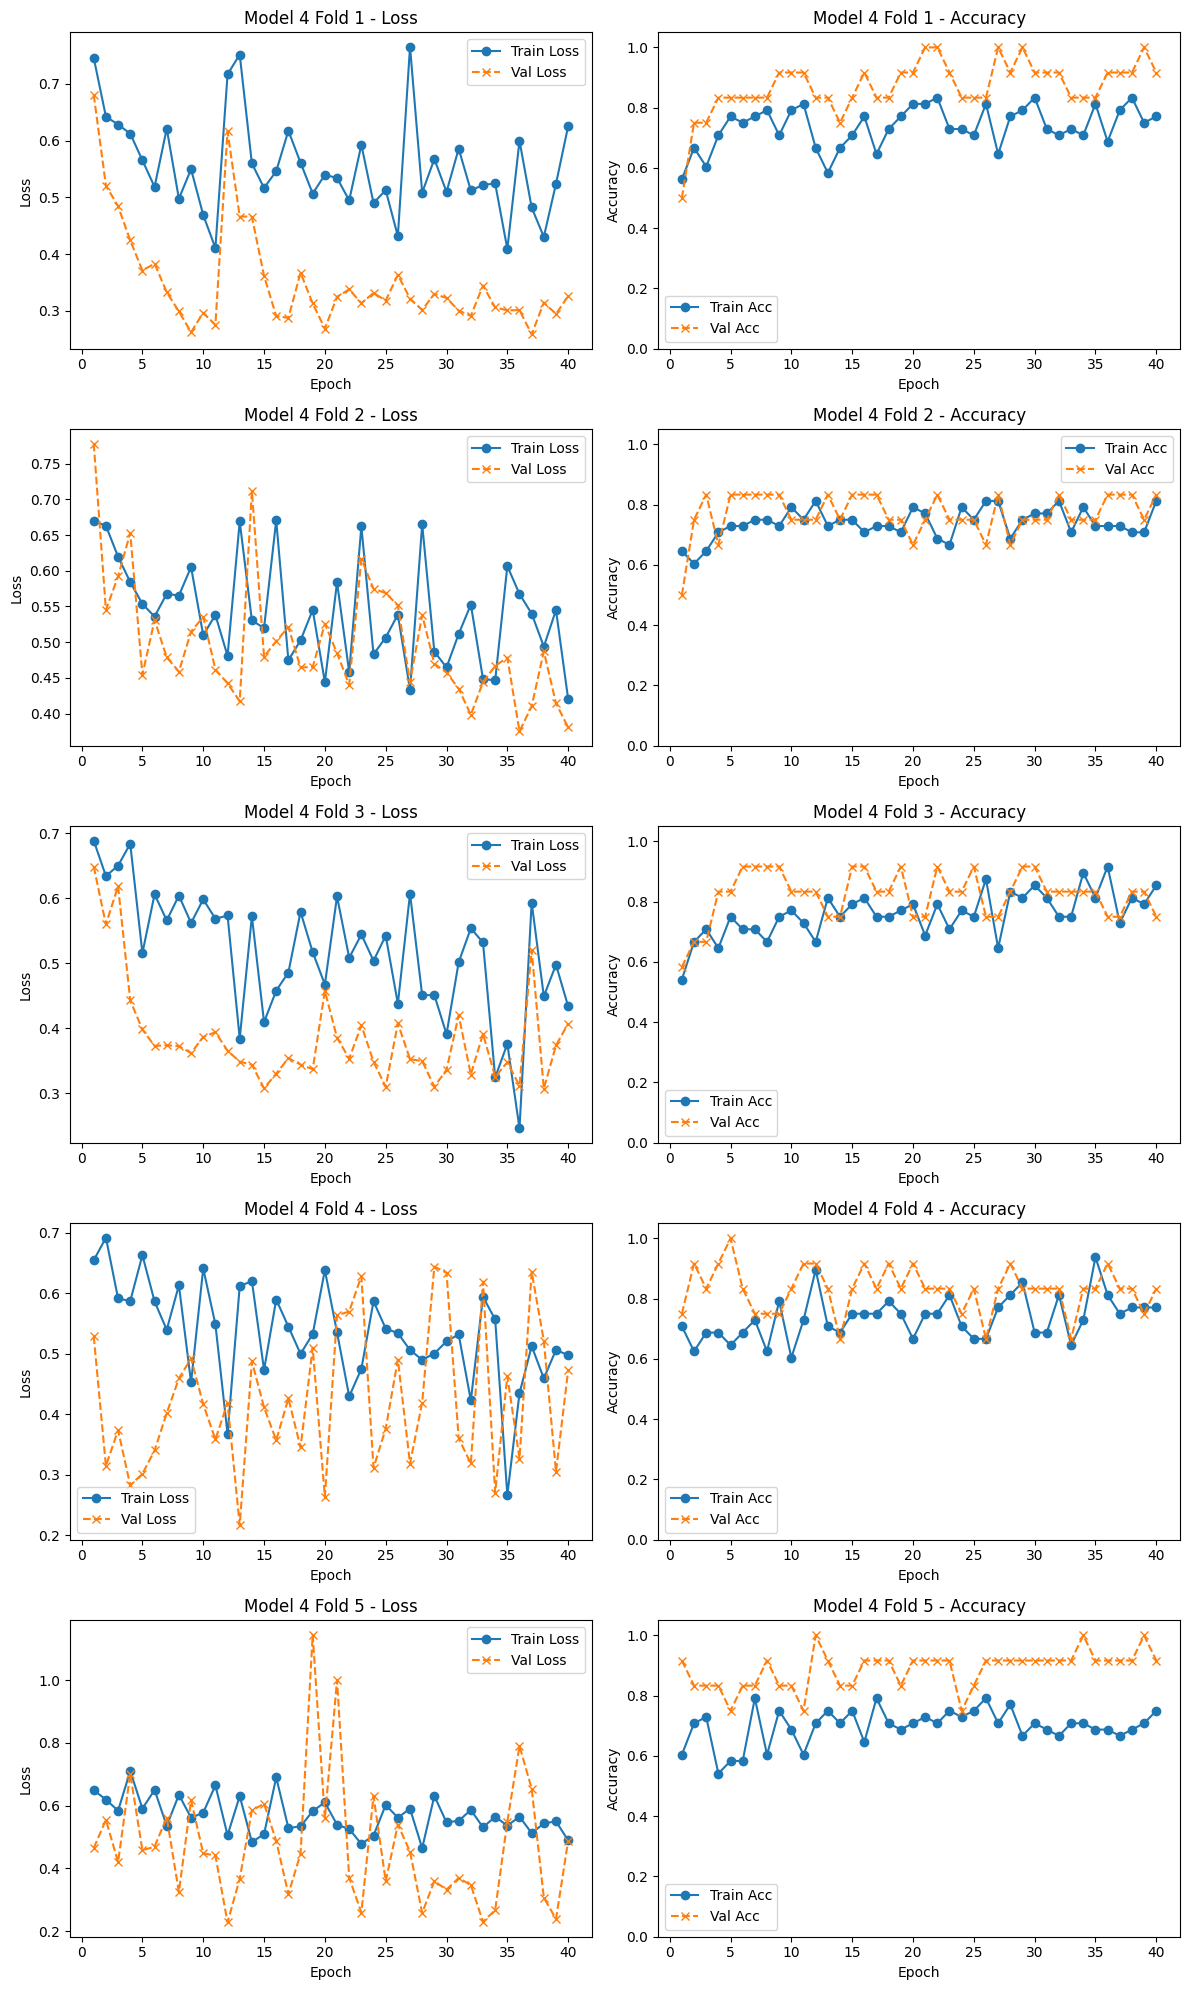

In [268]:
plot_histories(hist4, model_name="Model 4")

In [243]:
# logic to get confusion matrix from each model and fold
#   0 1
# 0
# 1
# Where top is predicted and side is actual value
# 0 is hog 1 is no hog
def get_confusion_matrix(model, dataloader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(x_batch)
            pred_labels = torch.argmax(logits, dim=1)

            preds.append(pred_labels.cpu().numpy())
            labels.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    cm = confusion_matrix(labels, preds)
    return cm

In [244]:
conf_mats = []
for fold in range(5):
    cm = get_confusion_matrix(trained_models[fold], val_loaders[fold])
    conf_mats.append(cm)
    print(f"Model 1 - Fold {fold+1}\n{cm}\n")

Model 1 - Fold 1
[[6 1]
 [1 4]]

Model 1 - Fold 2
[[7 0]
 [2 3]]

Model 1 - Fold 3
[[5 2]
 [1 4]]

Model 1 - Fold 4
[[7 0]
 [5 0]]

Model 1 - Fold 5
[[7 0]
 [1 4]]



In [247]:
conf_mats = []
for fold in range(5):
    cm = get_confusion_matrix(trained_models_2[fold], val_loaders[fold])
    conf_mats.append(cm)
    print(f"Model 2 - Fold {fold+1}\n{cm}\n")

Model 2 - Fold 1
[[7 0]
 [0 5]]

Model 2 - Fold 2
[[7 0]
 [1 4]]

Model 2 - Fold 3
[[5 2]
 [0 5]]

Model 2 - Fold 4
[[5 2]
 [0 5]]

Model 2 - Fold 5
[[7 0]
 [2 3]]



In [255]:
conf_mats = []
for fold in range(5):
    cm = get_confusion_matrix(trained_models_3[fold], val_loaders2[fold])
    conf_mats.append(cm)
    print(f"Model 3 - Fold {fold+1}\n{cm}\n")

Model 3 - Fold 1
[[5 2]
 [0 5]]

Model 3 - Fold 2
[[6 1]
 [1 4]]

Model 3 - Fold 3
[[5 2]
 [0 5]]

Model 3 - Fold 4
[[5 2]
 [0 5]]

Model 3 - Fold 5
[[6 1]
 [2 3]]



In [271]:
conf_mats = []
for fold in range(5):
    cm = get_confusion_matrix(trained_models_4[fold], val_loaders3[fold])
    conf_mats.append(cm)
    print(f"Model 4 - Fold {fold+1}\n{cm}\n")

Model 4 - Fold 1
[[7 0]
 [1 4]]

Model 4 - Fold 2
[[7 0]
 [2 3]]

Model 4 - Fold 3
[[5 2]
 [1 4]]

Model 4 - Fold 4
[[5 2]
 [0 5]]

Model 4 - Fold 5
[[7 0]
 [1 4]]



In [257]:
# more diagnosis to find best val accuracy from avg of each fold for the best epoch
def analyze_cv_results(histories, name="Model"):
    """
    histories: list of length 5 (one per fold)
               each element is (train_loss, val_loss, train_acc, val_acc)
    """
    num_folds = len(histories)
    num_epochs = len(histories[0][3])

    avg_val_acc = np.zeros(num_epochs)

    # Compute average val accuracy per epoch across folds
    for epoch in range(num_epochs):
        fold_accs = [histories[f][3][epoch] for f in range(num_folds)]
        avg_val_acc[epoch] = np.mean(fold_accs)

    # Find best epoch
    best_epoch = np.argmax(avg_val_acc) + 1
    best_acc = avg_val_acc[best_epoch - 1]

    print(f"\n===== {name} CV Analysis =====")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Mean Validation Accuracy: {best_acc:.4f}")

    return avg_val_acc, best_epoch, best_acc


In [276]:
avg1, best_ep1, best_acc1 = analyze_cv_results(hist,  "Model 1")
avg2, best_ep2, best_acc2 = analyze_cv_results(hist2, "Model 2")
avg3, best_ep3, best_acc3 = analyze_cv_results(hist3, "Model 3")
avg4, best_ep4, best_acc4 = analyze_cv_results(hist4, "Model 4")


===== Model 1 CV Analysis =====
Best Epoch: 19
Best Mean Validation Accuracy: 0.8000

===== Model 2 CV Analysis =====
Best Epoch: 32
Best Mean Validation Accuracy: 0.9167

===== Model 3 CV Analysis =====
Best Epoch: 25
Best Mean Validation Accuracy: 0.8833

===== Model 4 CV Analysis =====
Best Epoch: 16
Best Mean Validation Accuracy: 0.9000


In [259]:
def plot_avg_accuracy(avg_acc, name="Model"):
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(avg_acc)+1), avg_acc, marker="o")
    plt.title(f"{name} - Avg Validation Accuracy Across Folds")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Validation Accuracy")
    plt.grid(True)
    plt.show()

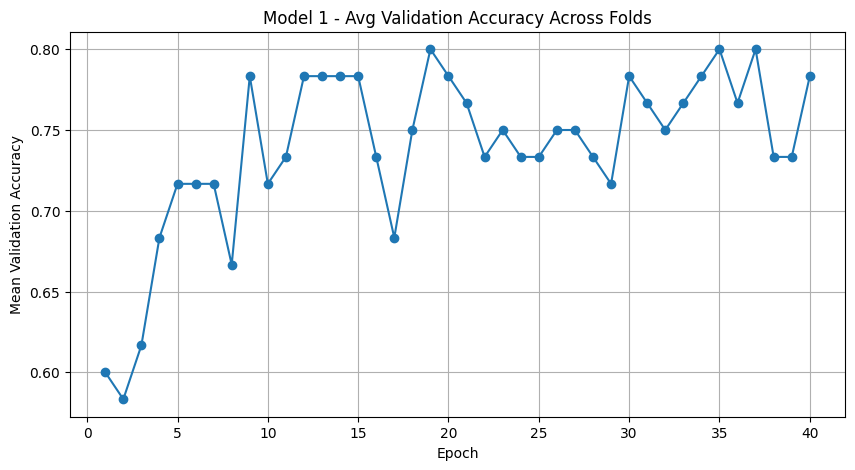

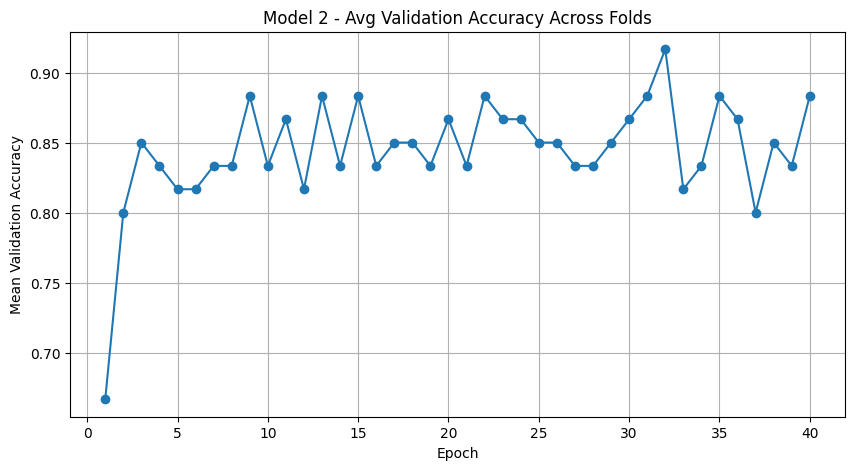

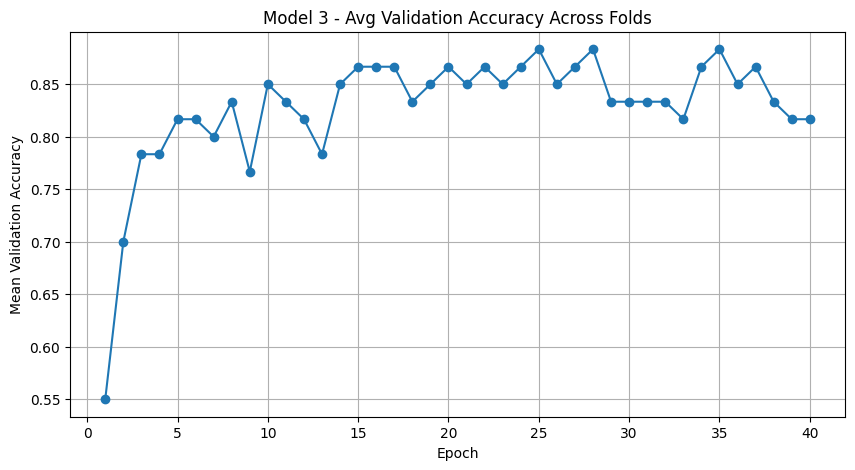

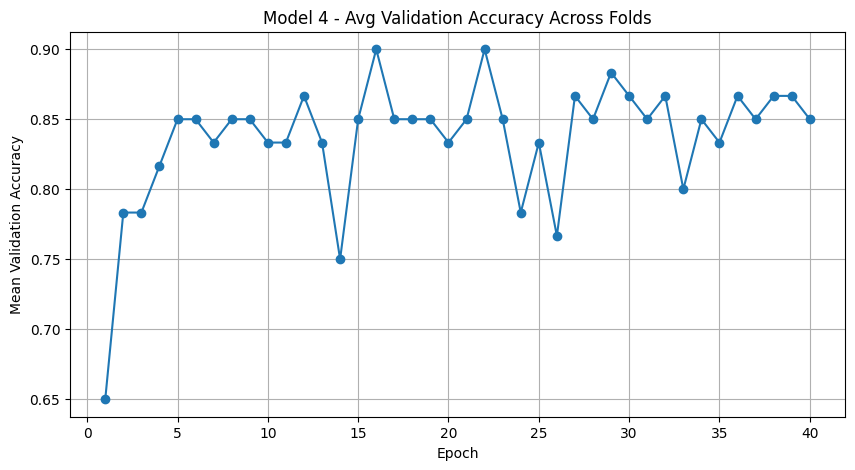

In [277]:
plot_avg_accuracy(avg1, "Model 1")
plot_avg_accuracy(avg2, "Model 2")
plot_avg_accuracy(avg3, "Model 3")
plot_avg_accuracy(avg4, "Model 4")

In [262]:
# Going with model 2 with a batch of 5 at lr of .001 and weight_decay of 1e-4 at 32 epochs

# Create the final model (Model 2)
final_model = create_model2()

# Loss and optimizer (same settings as CV)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 32  # from CV best epoch

# Tracking (optional)
final_train_loss = []
final_train_acc  = []

print("\n===== TRAINING FINAL FULL MODEL =====")

for epoch in range(num_epochs):
    final_model.train()

    epoch_loss = 0
    correct = 0
    total = 0

    for x_batch, y_batch in final_train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = final_model(x_batch)
        loss = loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking
        epoch_loss += loss.item() * y_batch.size(0)
        correct += (torch.argmax(pred, dim=1) == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = epoch_loss / total
    accuracy = correct / total

    final_train_loss.append(avg_loss)
    final_train_acc.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Loss: {avg_loss:.4f} "
          f"Train Acc: {accuracy:.4f}")

print("\n===== FINAL TRAINING COMPLETE =====")



===== TRAINING FINAL FULL MODEL =====
Epoch 1/32 Loss: 0.5662 Train Acc: 0.7000
Epoch 2/32 Loss: 0.4847 Train Acc: 0.8167
Epoch 3/32 Loss: 0.3845 Train Acc: 0.8333
Epoch 4/32 Loss: 0.4656 Train Acc: 0.8000
Epoch 5/32 Loss: 0.4367 Train Acc: 0.8500
Epoch 6/32 Loss: 0.3816 Train Acc: 0.8167
Epoch 7/32 Loss: 0.4441 Train Acc: 0.8000
Epoch 8/32 Loss: 0.3101 Train Acc: 0.9000
Epoch 9/32 Loss: 0.2762 Train Acc: 0.9000
Epoch 10/32 Loss: 0.3675 Train Acc: 0.8333
Epoch 11/32 Loss: 0.4898 Train Acc: 0.7833
Epoch 12/32 Loss: 0.3261 Train Acc: 0.8667
Epoch 13/32 Loss: 0.3252 Train Acc: 0.8833
Epoch 14/32 Loss: 0.3801 Train Acc: 0.8500
Epoch 15/32 Loss: 0.3444 Train Acc: 0.8833
Epoch 16/32 Loss: 0.3189 Train Acc: 0.9167
Epoch 17/32 Loss: 0.2669 Train Acc: 0.8500
Epoch 18/32 Loss: 0.4436 Train Acc: 0.8167
Epoch 19/32 Loss: 0.3392 Train Acc: 0.8667
Epoch 20/32 Loss: 0.3038 Train Acc: 0.8833
Epoch 21/32 Loss: 0.2840 Train Acc: 0.8833
Epoch 22/32 Loss: 0.2429 Train Acc: 0.9333
Epoch 23/32 Loss: 0.3402

In [263]:
save_path = "Group_28_CNN_FullModel.ph"

torch.save(final_model.state_dict(), save_path)

print(f"\nModel saved to: {save_path}")


Model saved to: Group_28_CNN_FullModel.ph


## How did you create your dataset and determine split of official logo versus not official logo?
we created the dataset by manually collecting images from Google Images and Etsy that either did or did not contain the official Arkansas Razorback hog logo. Images that clearly displayed the licensed hog were labeled as official logo examples, while images that showed stylized hogs, distorted versions of the logo, unrelated animal graphics, red artwork, or any other form of non licensed imagery were labeled as non logo examples. After assembling the dataset, I organized the images into two folders so that PyTorch’s ImageFolder utility could automatically read them and assign class indices. The final dataset contained approximately a 55 percent to 45 percent split, with slightly more official logo images. Rather than manually creating a training set and validation set, I used the StratifiedKFold procedure to produce five splits that preserved the same proportion of official and non official images in every fold. This approach ensured that each training and validation set reflected the underlying distribution of the original dataset and prevented biases that might arise from uneven sampling.

## Why did you choose the specific architecture for the final model?
I selected Model 2 as the final architecture because it consistently showed the strongest and most stable performance across all five cross validation folds. This model was better suited for high resolution 500 by 500 images and incorporated several architectural improvements that supported more effective feature learning. Each convolutional block included batch normalization, which helped stabilize gradients, reduce internal covariate shift, and improve generalization. The network also reduced the likelihood of overfitting by applying dropout within the fully connected layer and by using a global average pooling layer instead of flattening a large spatial tensor. Global average pooling significantly reduced the number of trainable parameters while still preserving the strongest features learned in the deeper layers. Model 2 achieved the highest mean validation accuracy at approximately 91.7 percent, which was substantially higher and more consistent than the other tested architectures. Its best generalization occurred at epoch 32, which validated the architectural choice and made it the clear candidate for full dataset training.

## How did you monitor and mitigate overfitting?
I monitored overfitting by examining the relationship between training accuracy, training loss, validation accuracy, and validation loss across all five cross validation folds. By reviewing how these metrics evolved over forty epochs for each fold, I was able to detect whether the model was memorizing the training images or learning features that generalized to unseen data. Several techniques were intentionally applied to prevent overfitting. The training transformation pipeline included substantial data augmentation, such as random horizontal flips, rotations, random resized crops, and color jittering, which increased visual variability and reduced the model’s dependence on specific pixel arrangements. The architecture incorporated batch normalization to stabilize training and dropout to reduce co adaptation in the final classifier. Weight decay was also used to penalize overly large weights. Most importantly, performing stratified fivefold cross validation allowed me to observe performance on multiple validation sets rather than just one. By averaging validation accuracy across folds and selecting epoch 32 as the point of highest generalization, I ensured that the final model did not train longer than necessary and that it maintained strong performance on unseen images.

## What future efforts do you recommend to improve model performance?
Future work on this project can focus on expanding the dataset and experimenting with more advanced modeling techniques. Increasing the number and diversity of images for both official and non official logos would significantly improve the model’s ability to generalize to real world inputs, especially edge cases that are visually similar to the official Razorback logo. Incorporating stronger augmentation such as cutout, mixup, or automated augmentation policies could further improve robustness. A major opportunity for improvement lies in adopting transfer learning by using pretrained models such as ResNet, MobileNet, or EfficientNet, which typically provide much stronger feature extraction capabilities than a custom architecture. Additional enhancements could include adding learning rate scheduling, implementing early stopping, and using test time augmentation to boost inference accuracy. Although the current model performs well, these improvements would likely increase accuracy, reduce overfitting, and help the classifier handle more challenging or ambiguous images.